In [1]:
import graspy
import numpy as np
from graspy.simulations import rdpg

In [2]:
from rerf.urerf import UnsupervisedRandomForest
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding

# 1. RDPG genetation

The experiment is to find two anomaly graphs in a time series of 12 RDPG (random dot product graph). The graphs have 100 dots and is saved as adjacency matrices. 
Non-outlier graphs are generated using a random vector sampled from a uniform distribution U(0.2, 0.8); outliers are generated using two factors: $\Delta$x and $\Delta$n. $\Delta$n controls the number of anomaly dots in the graph and is set as 20 and $\Delta$x controls how much the anomaly points drifts from non-outlier vectors, which is set as 0.1. 

In [3]:
def generateRDPG():
    n = 100
    X1 = np.zeros(n, )
    deltan=20
    deltax=.1
    t = 12

    for i in range(n):
        X1[i] = np.random.uniform(0.2, 0.8) # sample X from uniform distribution U(0.2, 0.8)

    # set graph 6 and 7 as outliers    
    At = np.zeros([t, n, n])
    Xt = np.zeros([t, n])
    Z = np.r_[deltax*np.ones([deltan//2, ]), -deltax*np.ones([deltan//2, ]), np.zeros([n-deltan, ])] 

    for i in range(12):
        Xt[i] = X1
        if i == 5:
            Xt[i] = X1+Z
        elif i == 6: 
            Xt[i] = X1-Z
    
        At[i] = rdpg(np.c_[Xt[i], Xt[i]])
    
    # get 12 time series graphs
    return At

# 2. MASE and OMNI test run

In the original paper, two embeddings are adopted, which are MASE and OMNI. First thing in the experiment is that I will try to recreate the p-value results in the paper. before that, I will do a single run of MASE and OMNI embedding on the RDPGs to see if it works properly in detecting the outliers. 

## 1) GrasPy's MASE

([<matplotlib.axis.XTick at 0x7f7dce4e2310>,
 <a list of 11 Text xticklabel objects>)

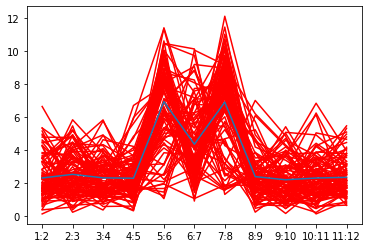

In [26]:
# a single run of MASE on the time series of graphs to see if it is effective
ys = np.zeros((100, 11))
for n_iter in range(100):
    # generate the graphs
    At = generateRDPG()
    # get a 2-dimensional MASE embedding of the graph
    d = 2
    mase = graspy.embed.MultipleASE(n_components=d, scaled=True)
    V = mase.fit_transform(At)
    
    # use the embedding result to transform the graphs
    Xhat = np.zeros((12, 100, d))
    for i in range(12):
        Rhat = V.T.dot(At[i]).dot(V)
        Xhat[i] = V.dot(Rhat)
    
    # compute the F-norm of the difference between two graphs as a metrics to detect outliers
    y = []
    for i in range(11):
        yhat = Xhat[i+1]-Xhat[i]
        y.append(np.linalg.norm(yhat))
    
    # plot the norms of every single trial as a record 
    plt.plot(y, c='r')
    ys[n_iter] = np.array(y)

# plot the average of the norms
avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.plot(avg)
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

([<matplotlib.axis.XTick at 0x7f7dce307310>,
 <a list of 11 Text xticklabel objects>)

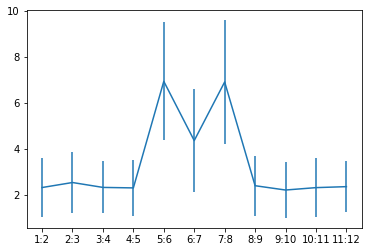

In [27]:
# plot the standard variance as errorbar
plt.errorbar(np.array(range(11)), avg, yerr=err)
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

It can be seen that the outliers are successfully detected, with the differences of Graph 5 vs. Graph 6, Graph 6 vs. Graph 7 and Graph 7 vs. Graph 8 are significantly larger than the other non-outliers. Although the norm of Graph 6 vs. Graph 7, which is supposed to be the largest, is smaller than the other two, the reason of which is still in the dark. 
j1 suggested that when using the MASE embedding I should set the parameter 'scaled' as True, I tried that but it didn't work, although it do narrowed the gap between them a little bit. Following this mindset, I tried tuning the other parameters as well, but it didn't work either. Amoung all the trials, simply changing the 'scaled' parameter seems the best. 

## 2) GrasPy's OMNI 

([<matplotlib.axis.XTick at 0x7f7de436fd50>,
 <a list of 11 Text xticklabel objects>)

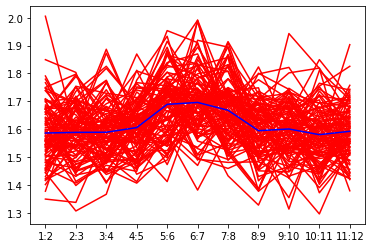

In [30]:
# a single run of OMNI using the GrasPy version. 
ys = np.zeros((100, 11))
for n_iter in range(100):
    # generate RDPGs
    At = generateRDPG()
    # get the OMNI embedding of the graphs with a dimension of 2
    omni = graspy.embed.OmnibusEmbed(n_components=2)
    Xhat = omni.fit_transform(At)

    y = []
    for i in range(11):
        # compute the F-norm of the difference between two graphs as a metrics to detect outliers
        yhat = Xhat[i+1]-Xhat[i]
        y.append(np.linalg.norm(yhat))
    # plot the norms of every single trial as a record
    ys[n_iter] = np.array(y)
    plt.plot(y, c='r')

# plot the average of the norms
plt.plot(ys.mean(0), c='b')
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

([<matplotlib.axis.XTick at 0x7f7dcc811690>,
 <a list of 11 Text xticklabel objects>)

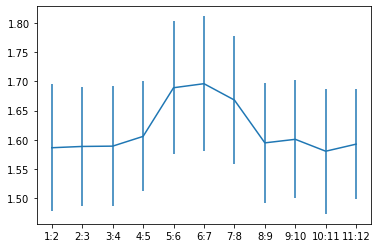

In [31]:
avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.errorbar(np.array(range(11)), avg, yerr=err)
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

Similarly, it can be seen that the outliers are successfully detected, with the differences of Graph 5 vs. Graph 6, Graph 6 vs. Graph 7 and Graph 7 vs. Graph 8 are significantly larger than the other non-outliers. However, the significance of the outliers seems not as good as what's in the paper. 

## 3) Nearest Common Ancestor

The basic idea of using distance metrics on this problem is use single graph adjacency embedding on every single graph to transform it into infomation that can be processed with random forest, and then use the distance metrics to detect the outlier, in which the judging criteria is the mean distance of one graph to all the other. Both nearest common ancestor and length of shortest path, which are developed in the first sprint is tried here, NCA got better results probably because that the result of NCA is more sparse. 

The algorithm can be summarized as: 
1. Obtain LSE for each graph with 4 components and get $\hat{V}$
2. Do dimensional reduction (SVD) and get $\hat{X}$
3. clf.fit($\hat{X}$)
4. D_nca = nearest_common_ancestor($\hat{X}$)
5. D = D_nca.mean()
6. Plot D

([<matplotlib.axis.XTick at 0x7f7dcc3785d0>,
 <a list of 12 Text xticklabel objects>)

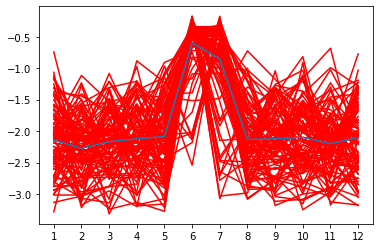

In [38]:
# a single trial to see if it can correctly detect the outliers. 
ys = np.zeros((100, 12))
for n_iter in range(100):
    At = generateRDPG()
    Vhat = np.zeros((100, 48))
    for i in range(12):
        # get the LSE embedding for every graph
        lse = graspy.embed.LaplacianSpectralEmbed(n_components = 4, check_lcc=False)
        Vhat[:, 4*i:4*(i+1)] = lse.fit_transform(At[i])
    
    # get the truncated SVD of the embedding and apply it to the graphs, 
    # getting the info needed for random forest classification
    U, sigma, V = np.linalg.svd(Vhat)
    V = U[:, 0]
    Xhat = np.zeros((12, 100))
    for i in range(12):
        Rhat = V.T.dot(At[i]).dot(V)
        Xhat[i] = Rhat*V
    
    # calculate the nearest common ancestor of the graphs as the metrics
    clf = RandomTreesEmbedding(n_estimators=10, max_depth=20, random_state=0)
    clf.fit(Xhat)
    n_sample = 12
    n_estimator = 10
    path = np.array(clf.decision_path(Xhat)[0].todense())
    d = path.dot(path.T)
    d_nca = 1-d / n_estimator
    
    # use the mean distance as the criteria to detect the outliers
    y = d_nca.mean(0)
    
    # plot every single trial as a record
    plt.plot(y, c='r')
    ys[n_iter] = np.array(y)

# plot the mean result 
avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.plot(avg)
plt.xticks(np.array(range(12)), np.array(range(1, 13)))

The distance is negative because some of the RDPG sets generated are not fully connected, which will result in a warning. The overall trend and result won't change. 

([<matplotlib.axis.XTick at 0x7f7dcc3d76d0>,
 <a list of 12 Text xticklabel objects>)

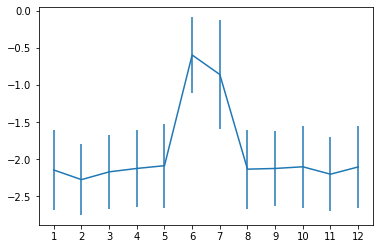

In [39]:
# plot the result as an errorbar
plt.errorbar(np.array(range(12)), avg, yerr=err)
plt.xticks(np.array(range(12)), np.array(range(1, 13)))

It is obvious that Graph 6 and Graph 7 are the outliers, and they are separated directly, without the need for an extra step of deriving the outliers given the norms of difference between neighboring graph pairs. 

# 3. P-value calculation

The p-value calculation in this case is carried out as in the paper: 
![image.png](1.png)

## 1) p-value of MASE

([<matplotlib.axis.XTick at 0x7f7dcc4682d0>,
 <a list of 11 Text xticklabel objects>)

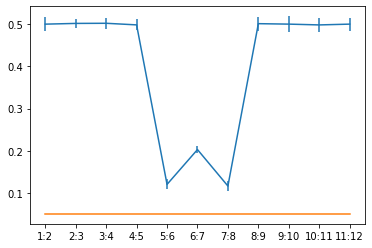

In [36]:
# run 20 trials and get the average and standard variation of the p-value
P_mase = np.zeros((11, 20))
for n_trial in range(20):
    # the first 1000 runs will get a general pattern of non-outlier graphs
    M = 1000
    N = 500
    T = np.zeros(1000, )
    for n_iter in range(M):
        # this part is the same as the single trial MASE
        At = generateRDPG()
        d = 2
        mase = graspy.embed.MultipleASE(n_components=d, scaled=True)
        V = mase.fit_transform(At)

        Xhat = np.zeros((12, 100, d))
        for i in range(12):
            Rhat = V.T.dot(At[i]).dot(V)
            Xhat[i] = V.dot(Rhat)

        y = []
        for i in range(11):
            yhat = Xhat[i+1]-Xhat[i]
            y.append(np.linalg.norm(yhat))

        # use the first difference as the pattern
        T[n_iter] = y[0]

    p2 = np.zeros(11, )

    # the next 500 runs are used to compute the p-value
    for n_iter in range(N):
        # this part is the same as the single trial MASE
        At = generateRDPG()
        d = 2
        mase = graspy.embed.MultipleASE(n_components=d, scaled=True)
        V = mase.fit_transform(At)

        Xhat = np.zeros((12, 100, d))
        for i in range(12):
            Rhat = V.T.dot(At[i]).dot(V)
            Xhat[i] = V.dot(Rhat)

        y = []
        for i in range(11):
            yhat = Xhat[i+1]-Xhat[i]
            y.append(np.linalg.norm(yhat))

        # compare the norms with the general pattern
        # if the norms is less than the general pattern, then the p-value count increases
        for j in range(M):
            for k in range(11):
                if y[k]<T[j]:
                    p2[k] += 1

    # get the mean value over trials as the p-value
    p2 = p2 / M / N
    P_mase[:, n_trial] = p2

# draw the errorbar of a total of 20 trials
avg = np.mean(P_mase, axis=1)    
err = np.std(P_mase, axis=1)
plt.errorbar(np.array(range(11)), avg, yerr=err)
# draw the 0.05 significance line
plt.plot(0.05*np.ones(11, ))
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

The result in the paper is posted below: 

![image.png](2.png)

In the paper, MASE failed to reach the 0.05 significance barrier and the norms for Graph 5 vs. Graph 6 and Graph 7 vs. Graph 8 is 
significantly worse than Graph 6 vs. Graph 7. 

The overall trend is the same except for Graph 6 vs. Graph 7, which can be predicted according to the test run of MASE we did earlier. 

Also, according to Pedigo's advice, I did multiple runs of p-value calculation and drew an errorbar version of the plot. 

## 2) p-value of OMNI

([<matplotlib.axis.XTick at 0x7f7dcc4c39d0>,
 <a list of 11 Text xticklabel objects>)

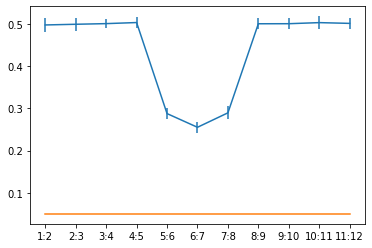

In [37]:
# the main idea is the same as the p-value calculation of MASE
# only the embedding is changed, so I will not comment this session in detail
P_omni = np.zeros((11, 20))
for n_trial in range(20):
    M = 1000
    N = 500
    T = np.zeros(1000, )
    for n_iter in range(M):
        At = generateRDPG()
        omni = graspy.embed.OmnibusEmbed(n_components=2)
        Xhat = omni.fit_transform(At)

        y = []
        for i in range(11):
            yhat = Xhat[i+1]-Xhat[i]
            y.append(np.linalg.norm(yhat))

        T[n_iter] = y[0]

    p = np.zeros(11, )

    for n_iter in range(N):
        At = generateRDPG()
        omni = graspy.embed.OmnibusEmbed(n_components=2)
        Xhat = omni.fit_transform(At)

        y = []
        for i in range(11):
            yhat = Xhat[i+1]-Xhat[i]
            y.append(np.linalg.norm(yhat))

        for j in range(M):
            for k in range(11):
                if y[k]<T[j]:
                    p[k] += 1

    p = p / M / N
    P_omni[:, n_trial] = p

avg = np.mean(P_omni, axis=1)    
err = np.std(P_omni, axis=1)
plt.errorbar(np.array(range(11)), avg, yerr=err)
plt.plot(0.05*np.ones(11, ))
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

The result in the paper is posted below: 

![image.png](3.png)

We can see that in the paper, OMNI reaches the 0.05 significance barrier and has better performance compared to MASE. 

However, in the GrasPy implementation, OMNI failed to reach the 0.05 significance barrier, although the overall trend is the same. The p-value for Graph 5 vs. Graph 6 and Graph 7 vs. Graph 8 are almost the same as in the paper, but the p-value for Graph 6 vs. Graph 7 is worse.  

## 3) p-value of nearest common ancestor

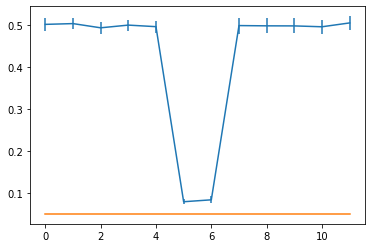

In [43]:
# the main idea is the same as the p-value calculation of MASE
# only the embedding is changed, so I will not comment this session in detail
P_nca = np.zeros((12, 20))
for n_trial in range(20):
    M = 1000
    N = 500
    T = np.zeros(1000, )
    for n_iter in range(M):
        At = generateRDPG()
        d = 4
        Vhat = np.zeros((100, 12*d))
        for i in range(12):
            lse = graspy.embed.LaplacianSpectralEmbed(n_components = d, check_lcc=False)
            Vhat[:, d*i:d*(i+1)] = lse.fit_transform(At[i])

        U, sigma, V = np.linalg.svd(Vhat)
        V = U[:, 0]
        Xhat = np.zeros((12, 100))
        for i in range(12):
            Rhat = V.T.dot(At[i]).dot(V)
            Xhat[i] = Rhat*V

        clf = RandomTreesEmbedding(n_estimators=10, max_depth=15, random_state=0)
        clf.fit(Xhat)
        n_sample = 12
        n_estimator = 10
        path = np.array(clf.decision_path(Xhat)[0].todense())
        d = path.dot(path.T)
        d_nca = 1-d / n_estimator

        y = d_nca.mean(0)
        T[n_iter] = y[0]

    p = np.zeros(12, )

    for n_iter in range(N):
        At = generateRDPG()
        d = 4
        Vhat = np.zeros((100, 12*d))
        for i in range(12):
            lse = graspy.embed.LaplacianSpectralEmbed(n_components = d, check_lcc=False)
            Vhat[:, d*i:d*(i+1)] = lse.fit_transform(At[i])

        U, sigma, V = np.linalg.svd(Vhat)
        V = U[:, 0]
        Xhat = np.zeros((12, 100))
        for i in range(12):
            Rhat = V.T.dot(At[i]).dot(V)
            Xhat[i] = Rhat*V

        clf = RandomTreesEmbedding(n_estimators=10, max_depth=15, random_state=0)
        clf.fit(Xhat)
        n_sample = 12
        n_estimator = 10
        path = np.array(clf.decision_path(Xhat)[0].todense())
        d = path.dot(path.T)
        d_nca = 1-d / n_estimator

        y = d_nca.mean(0)
        for j in range(M):
            for k in range(12):
                if y[k]<T[j]:
                    p[k] += 1

    p = p / M / N
    P_nca[:, n_trial] = p

avg = np.mean(P_nca, axis=1)    
err = np.std(P_nca, axis=1)
plt.errorbar(np.array(range(12)), avg, yerr=err)
plt.plot(0.05*np.ones(12, ))

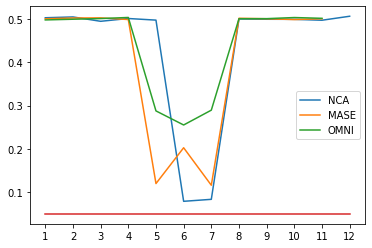

In [45]:
plt.plot(np.mean(P_nca, axis=1), label='NCA')
plt.plot(np.mean(P_mase, axis=1), label='MASE')
plt.plot(np.mean(P_omni, axis=1), label='OMNI')
plt.plot(0.05*np.ones(12, ))
plt.xticks(np.array(range(12)), np.array(range(1, 13)))
plt.legend()

for now, NCA has the best performance among all the methods, but OMNI did much worse than it did in the paper and 6:7 p-value of MASE look weird. OMNI is supposed to do better but didn't, and 6:7 of MASE is supposed to have lower p-value than 5:6 and 7:8. 

## 4) Conclusion on time series outlier detection 

If we compare the result from my simulation ,NCA has the best results. 

If we take the results in the paper, NCA did better in the way that for the two pairs that are different by Z, which are 5:6 and 7:8, the p-value is much better given same dimension scenario, and we don't need to calculate the norms of the difference between neighboring graph pairs since we can directly get the outliers using classification. However, MASE and OMNI can give some insight into the difference between outliers —— the difference of Graph 6 vs. 7, which is 2*Z, is visibly larger than Graph 5vs. 6 and Graph 7 vs. 8 according to the p-value. 

# 4. dot-wise classification

In this task, we want to find which ones of the 100 dots are outliers in the graph. The $\Delta$x is set as 0.15 and $\Delta$n is set as 40. 

In [54]:
def generateRDPG_dot():
    n = 100
    X1 = np.zeros(n, )
    deltan=40
    deltax=.15
    t = 12

    for i in range(n):
        X1[i] = np.random.uniform(0.2, 0.8) # sample X from uniform distribution U(0.2, 0.8)

    # set graph 6 and 7 as outliers    
    At = np.zeros([t, n, n])
    Xt = np.zeros([t, n])
    Z = np.r_[deltax*np.ones([deltan//2, ]), -deltax*np.ones([deltan//2, ]), np.zeros([n-deltan, ])] 

    for i in range(12):
        Xt[i] = X1
        if i == 5:
            Xt[i] = X1+Z
        elif i == 6: 
            Xt[i] = X1-Z
    
        At[i] = rdpg(np.c_[Xt[i], Xt[i]])
    
    # get 12 time series graphs
    return At

## the NCA method

The idea is that we take out the graphs that are already detected as outliers, plug them into a random forest as a 100 sample×100 feature classification problem, and we can get the following results. 

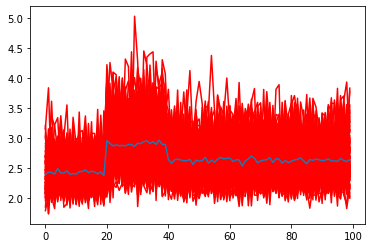

In [59]:
ys = np.zeros((100, 100))
for n_iter in range(100):
    At = generateRDPG_dot()
    
    clf = RandomTreesEmbedding(n_estimators=20, max_depth=20, random_state=0)
    clf.fit(At[5])
    n_sample = 100
    n_estimator = 20
    path = np.array(clf.decision_path(At[5])[0].todense())
    d = path.dot(path.T)
    d_nca = d / n_estimator
    
    y = d_nca.mean(0)
    
    plt.plot(y, c='r')
    ys[n_iter] = np.array(y)

avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.plot(avg)

<ErrorbarContainer object of 3 artists>

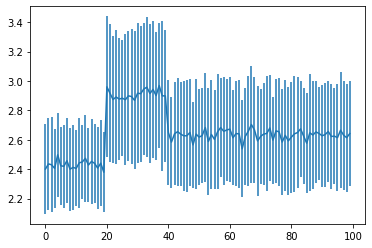

In [60]:
plt.errorbar(np.array(range(100)), avg, yerr=err)

We can see that for Graph 6, the dots are classified into three groups: the first 20, 20 through 40 which are two separate types of outliers, and the rest which are not outliers. 

The result is similar for Graph 7, which is posted below

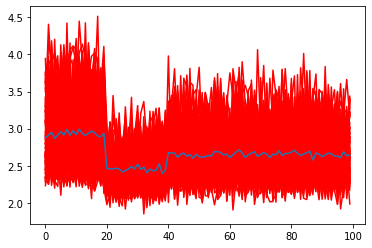

In [61]:
ys = np.zeros((100, 100))
for n_iter in range(100):
    # generate the RDPGs
    At = generateRDPG_dot()
    
    # plug the adjacency matrix into the random forest as a 100 sample, 100 feature classification problem
    clf = RandomTreesEmbedding(n_estimators=100, max_depth=20, random_state=0)
    clf.fit(At[6])
    n_sample = 100
    n_estimator = 100
    # compute the depth of the nearest common ancestor as the distance
    path = np.array(clf.decision_path(At[6])[0].todense())
    d = path.dot(path.T)
    d_nca = d / n_estimator
    
    y = d_nca.mean(0)
    
    plt.plot(y, c='r')
    ys[n_iter] = np.array(y)

# plot the mean distance
avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.plot(avg)

<ErrorbarContainer object of 3 artists>

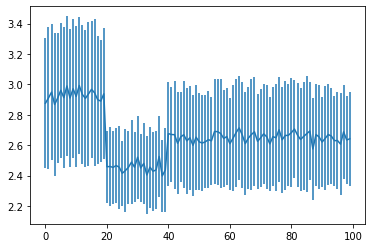

In [62]:
# plot it as an errorbar
plt.errorbar(np.array(range(100)), avg, yerr=err)

The result here maybe superior to the MASE and OMNI classification in the way that it can tell the difference between two different types of outliers, which MASE and OMNI cannot. 

## p-value calculation 

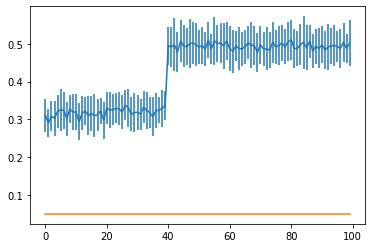

In [67]:
# the main idea is the same as the p-value calculation of MASE
# only the embedding is changed, so I will not comment this session in detail
# the M and N are modified because they are taking too much time
P_dot = np.zeros((100, 20))
for n_trial in range(20):
    M = 100
    N = 50
    T = np.zeros(1000, )
    for n_iter in range(M):
        At = generateRDPG_dot()

        clf = RandomTreesEmbedding(n_estimators=100, max_depth=20, random_state=0)
        clf.fit(At[6])
        n_sample = 100
        n_estimator = 100
        path = np.array(clf.decision_path(At[6])[0].todense())
        d = path.dot(path.T)
        d_nca = d / n_estimator

        y = d_nca.mean(0)

        T[n_iter] = y[99]

    p = np.zeros(100, )

    for n_iter in range(N):
        At = generateRDPG_dot()
        
        clf = RandomTreesEmbedding(n_estimators=100, max_depth=20, random_state=0)
        clf.fit(At[6])
        n_sample = 100
        n_estimator = 100
        path = np.array(clf.decision_path(At[6])[0].todense())
        d = path.dot(path.T)
        d_nca = d / n_estimator

        y = d_nca.mean(0)
        for j in range(M):
            for k in range(100):
                if k<20:
                    if y[k]<T[j]:
                        p[k] += 1
                elif k<40:
                    if y[k]>T[j]:
                        p[k] += 1
                else:
                    if y[k]<T[j]:
                        p[k] += 1

    p = p / M / N
    P_dot[:, n_trial] = p

avg = np.mean(P_dot, axis=1)    
err = np.std(P_dot, axis=1)
plt.errorbar(np.array(range(100)), avg, yerr=err)
plt.plot(0.05*np.ones(100, ))

Once converted to p-value visualization, it is obvious that the first 40 dots are outliers, but they did not reach the 0.05 significance barrier. 

In the paper, for Graph 6 vs. Graph 7, The p-value of dot-wise detection reaches the 0.05 significance barrier but in other graphs they do not. 
![image.png](4.png)

# 5. Overall conclusion

My method proves to be better than OMNI and MASE in time series outlier detection, but fails to get better results when it comes to dot-wise outlier detection. 

I think all the main differences of distance metrics methods based on random forest and MASE/OMNI come from the fact that MASE/OMNI focus the difference between neighboring graphs while my method is applied directly on the 12 time series graphs. This results in the difference in whether being able to detect different types of outliers and thus the performance gap concerning Graph 5 vs. 6 and Graph 6 vs. 7. I have not found a way to compare the methods on a same level, but according to rough p-value comparison, it's safe to say that in time series classification, distance metrics can do a good job. And in dot-wise classification, it can detect outliers clearly, though not able to push beyond the significance barrier. 

Last but not least, thank you all for your help and advice! There are still some mysteries unsolved and I am open for more advice and also open to working on this or other projects after this semester ends. 